In [3]:
# import VAE from other script
import os

from MicrobeWGANGP import WGANGP

# import necessary packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import skbio
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

# disable eager execution
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [8]:
# load fracking data and make necessary changes to shape
combined_metadata = pd.read_csv(r"C:\Users\Peter\Desktop\Classes\Summer 2021\CSI Research\edited_mt_combined_metadata.txt", sep = "\t")
species_table = pd.read_csv(r"C:\Users\Peter\Desktop\Classes\Summer 2021\CSI Research\norm_filtered_species_table.txt", sep = "\t")
species_table

,SampleID,AB1_S65_L006,AB3_S66_L006,BCD1_S67_L006,BCD2_S68_L006,BCU1_S69_L006,BCU3_S70_L006,ECD1_S71_L006,ECD3_S72_L006,ECM2_S73_L006,...,PR_1_W_S201_L006,PR_3_W_S202_L006,RR_1_S150_L005,RR_1_W_S168_L005,RR_3_S188_L006,RR_3_W_S204_L006,SS_1_S187_L006,SS_1_W_S167_L005,SS_3_S149_L005,SS_3_W_S203_L006
0,d__Archaea;p__Candidatus_Korarchaeota;g__Candi...,0.850561,2.26684,2.96983,2.2124,7.24569,13.8132,3.18246,7.310830,6.12416,...,16.86720,4.47461,0.00000,16.31850,3.08518,13.5262,0.294586,6.28646,2.38809,8.07872
1,d__Archaea;p__Candidatus_Lokiarchaeota;g__Cand...,109.297000,121.04900,223.72700,110.6200,227.20400,139.7100,708.62700,581.211000,329.98400,...,412.54300,244.82500,34.80690,247.49700,49.87700,298.8070,97.802400,185.45100,91.74230,222.16500
2,d__Archaea;p__Candidatus_Micrarchaeota;g__Cand...,21.264000,35.36270,22.76870,57.9649,17.07910,21.3117,79.03100,96.563800,62.32230,...,86.44430,38.35380,3.00059,46.23570,8.22713,79.3129,9.721320,37.71880,7.56227,34.33460
3,d__Archaea;p__Candidatus_Micrarchaeota;g__Cand...,28.068500,23.12170,1.97989,12.8319,13.45630,14.6025,0.00000,0.913853,0.00000,...,9.83919,12.14540,1.80036,8.15925,0.00000,12.9114,5.007950,40.86200,5.17419,18.17710
4,d__Archaea;p__Candidatus_Thermoplasmatota;c__T...,155.227000,178.62700,116.81300,135.8410,64.69370,102.6120,695.36700,821.859000,608.09300,...,421.68000,329.84300,29.40580,345.40800,39.59310,494.9370,103.105000,298.60700,87.36420,280.73500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8213,d__Viruses;s__Wuhan_fly_virus_4,0.000000,0.00000,0.00000,0.0000,0.00000,0.0000,0.00000,0.000000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.000000,0.00000,0.00000,0.00000
8214,d__Viruses;s__Wuhan_insect_virus_27,0.000000,0.00000,0.00000,0.0000,0.00000,0.0000,0.00000,0.000000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.000000,0.00000,0.00000,0.00000
8215,d__Viruses;s__Wuhan_millipede_virus_3,0.000000,0.00000,0.00000,0.0000,0.00000,0.0000,0.00000,0.000000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.000000,0.00000,0.00000,0.00000
8216,d__Viruses;s__Xingshan_nematode_virus_6,0.000000,0.00000,0.00000,0.0000,0.00000,0.0000,0.00000,0.000000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.000000,0.00000,0.00000,0.00000


In [3]:
# define X (input): remove metadata tags
X = merged_data.iloc[:, :-17]

# define y (output): Select only HF status
y = merged_data.loc[:, "HF_Status"]
y = np.where(y == "HF+", 1, 0)

# convert y to float32 so true values and preds are same data type, then convert to keras tensor
y = y.astype('float32')

print(X.shape, y.shape)

(99, 8218) (99,)


[[     0.          15774.68807441 220993.11870281 ... 171255.76737759
   94243.60223868 183495.72046228]
 [ 15774.68807441      0.         220822.9292804  ... 167252.21572531
   89574.13299709 180254.84921396]
 [220993.11870281 220822.9292804       0.         ... 115791.3558491
  164427.92534252 133875.53892065]
 ...
 [171255.76737759 167252.21572531 115791.3558491  ...      0.
   91352.56921294  61996.76150357]
 [ 94243.60223868  89574.13299709 164427.92534252 ...  91352.56921294
       0.         115989.96093646]
 [183495.72046228 180254.84921396 133875.53892065 ...  61996.76150357
  115989.96093646      0.        ]]


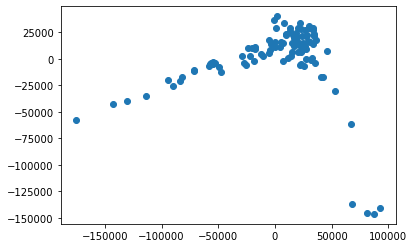

In [4]:
# run PCoA on original data:

#create distance matrix
distance_matrix = squareform(pdist(X.values, "euclid"))
print(distance_matrix)

#run PCoA on distance matrix
original_pcoa = skbio.stats.ordination.pcoa(distance_matrix)

#plot PCoA
plt.scatter(original_pcoa.samples['PC1'], original_pcoa.samples['PC2'])
plt.show()

In [5]:
# split X and y into train and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(79, 8218) (20, 8218) (79,) (20,)


In [6]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [7]:
# create WGAN-GP
gan = WGANGP(input_dim = (X_train.shape[1],),
             critic_dense_neurons = [2048, 1024, 512, 256, 128, 64, 32, 16],
             critic_batch_norm_momentum = None,
             critic_activation = 'leaky_relu',
             critic_dropout_rate = .25,
             critic_learning_rate = 0.0002,
             generator_initial_dense_layer_size = 512,
             generator_dense_neurons = [1024, 2048, X_train.shape[1]],
             generator_batch_norm_momentum = 0.9,
             generator_activation = 'leaky_relu',
             generator_dropout_rate = .25,
             generator_learning_rate = 0.0002,
             optimizer = 'adam',
             grad_weight = 10,
             z_dim = 100,
             batch_size = 64)

In [8]:
gan.critic.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    [(None, 8218)]            0         
_________________________________________________________________
critic_dense_0 (Dense)       multiple                  16832512  
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
critic_dense_1 (Dense)       multiple                  2098176   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0     

In [9]:
gan.generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               51712     
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
generator_dense_0 (Dense)    (None, 1024)              525312    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096

In [10]:
EPOCHS = 1000
N_CRITIC = 5
BATCH_SIZE = 64

gan.train(     
    X_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , n_critic = N_CRITIC
)

0, (5, 1) [D Loss: (9.6)(R -0.4, F 0.0, I 1.0)] [G loss: -0.0]
1, (5, 1) [D Loss: (-9.2)(R -19.0, F 0.0, I 1.0)] [G loss: -0.0]
2, (5, 1) [D Loss: (-545.5)(R -550.5, F 0.0, I 0.5)] [G loss: -0.3]
3, (5, 1) [D Loss: (-10635.5)(R -10849.7, F 1.1, I 21.3)] [G loss: -14.8]
4, (5, 1) [D Loss: (-97896.0)(R -119596.6, F 14.3, I 2168.6)] [G loss: -137.8]
5, (5, 1) [D Loss: (-349674.7)(R -628116.6, F 72.7, I 27836.9)] [G loss: -404.3]
6, (5, 1) [D Loss: (-614663.9)(R -1159585.8, F 109.6, I 54481.2)] [G loss: -508.2]
7, (5, 1) [D Loss: (-1052020.8)(R -1938507.9, F 159.5, I 88632.8)] [G loss: -643.4]
8, (5, 1) [D Loss: (-1201645.2)(R -2352017.0, F 192.0, I 115018.0)] [G loss: -637.3]
9, (5, 1) [D Loss: (-1404698.8)(R -2771321.2, F 243.2, I 136637.9)] [G loss: -705.6]
10, (5, 1) [D Loss: (-1305016.2)(R -2711565.5, F 293.2, I 140625.6)] [G loss: -714.6]
11, (5, 1) [D Loss: (-1534561.8)(R -3074578.8, F 411.5, I 153960.5)] [G loss: -819.1]
12, (5, 1) [D Loss: (-1444252.8)(R -2861108.0, F 406.6, I 141

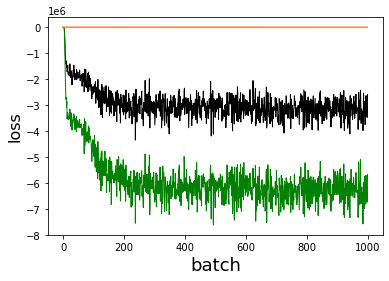

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=1)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=1)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=1)
plt.plot(gan.g_losses, color='orange', linewidth=1)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.show()

In [12]:
# generate simulated samples

# create noise vector (1000 samples of length z_dim):
noise = np.random.normal(0, 1, (1000, gan.z_dim))

# create samples from noise
gen_smps = gan.generator.predict(noise)
gen_smps

C:\Users\Peter\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


array([[ 0.37646028,  0.9986941 , -0.7889427 , ...,  0.9962528 ,
         0.9923582 ,  0.99056715],
       [ 0.94767076,  0.99896663,  0.88108784, ..., -0.47422948,
        -0.4636514 , -0.9987978 ],
       [ 0.89654905,  0.99938494,  0.9911481 , ..., -0.8436174 ,
        -0.25361514, -0.6628575 ],
       ...,
       [ 0.95175165,  0.9992677 ,  0.9112737 , ..., -0.50974244,
        -0.57425976, -0.99888396],
       [ 0.83115745,  0.99988365, -0.99988765, ...,  0.9999937 ,
         0.9999801 ,  0.98038465],
       [ 0.54363626,  0.99997884,  0.9986452 , ..., -0.7463918 ,
         0.6173818 ,  0.8539386 ]], dtype=float32)

[[  0.         126.76791521 118.30074299 ... 127.04283347  47.68719386
   97.7210706 ]
 [126.76791521   0.          90.09798619 ...   2.73174705 117.48954259
  132.04919178]
 [118.30074299  90.09798619   0.         ...  89.94384721 127.90655672
   67.79339341]
 ...
 [127.04283347   2.73174705  89.94384721 ...   0.         117.80377097
  132.02415878]
 [ 47.68719386 117.48954259 127.90655672 ... 117.80377097   0.
  119.47041134]
 [ 97.7210706  132.04919178  67.79339341 ... 132.02415878 119.47041134
    0.        ]]


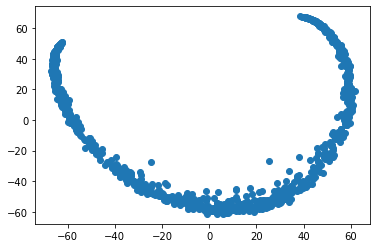

In [13]:
# run PCoA on synthetic data:

#create distance matrix
gen_distance_matrix = squareform(pdist(gen_smps, "euclid"))
print(gen_distance_matrix)

#run PCoA on distance matrix
generated_pcoa = skbio.stats.ordination.pcoa(gen_distance_matrix)

#plot PCoA
plt.scatter(generated_pcoa.samples['PC1'], generated_pcoa.samples['PC2'])
plt.show()